# Homework 9: Unsupervised Learning

## Download the Dataset

In [1]:
!gdown --id '1BZb2AqOHHaad7Mo82St1qTBaXo_xtcUc' --output trainX.npy 
!gdown --id '152NKCpj8S_zuIx3bQy0NN5oqpvBjdPIq' --output valX.npy 
!gdown --id '1_hRGsFtm5KEazUg2ZvPZcuNScGF-ANh4' --output valY.npy 
!mkdir checkpoints
!ls

Downloading...
From: https://drive.google.com/uc?id=1BZb2AqOHHaad7Mo82St1qTBaXo_xtcUc
To: /content/trainX.npy
26.1MB [00:01, 24.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=152NKCpj8S_zuIx3bQy0NN5oqpvBjdPIq
To: /content/valX.npy
100% 1.54M/1.54M [00:00<00:00, 94.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_hRGsFtm5KEazUg2ZvPZcuNScGF-ANh4
To: /content/valY.npy
100% 4.13k/4.13k [00:00<00:00, 6.90MB/s]
mkdir: cannot create directory ‘checkpoints’: File exists
checkpoints	prediction_invert.csv  trainX.npy  valY.npy
prediction.csv	sample_data	       valX.npy


## Prepare the Training Data

- Since the original image pixel is in the range of 0 ~ 255 as `int`, we need to transform it into the range of -1 ~ 1 as `float`.

In [2]:
import numpy as np

def preprocess(image_list):
    """Normalize the image and permute it from (N, H, W, C) to (N, C, H, W).
    Args:
        image_list: list of images (9000, 32, 32, 3)
    Returns:
        image_list: list of images (9000, 3, 32, 32)
    """
    image_list = np.array(image_list)
    image_list = np.transpose(image_list, (0, 3, 1, 2))
    image_list = (image_list / 255.0) * 2 - 1
    image_list = image_list.astype(np.float32)
    return image_list

In [3]:
from torch.utils.data import Dataset

class ImgDataset(Dataset):
    def __init__(self, image_list):
        self.image_list = image_list
    def __len__(self):
        return len(self.image_list)
    def __getitem__(self, idx):
        image = self.image_list[idx]
        return image

- Preprocess the training data.
- Do not use validation set as training data.

In [4]:
from torch.utils.data import DataLoader

trainX = np.load('trainX.npy')
trainX_preprecessed = preprocess(trainX)
img_dataset = ImgDataset(trainX_preprecessed)

## Some Useful Functions
- Compute the number of parameters.
- Fix the random seed.

In [5]:
import random
import torch

def count_parameters(model, only_trainable=False):
    if only_trainable:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # if using multi-GPU
    np.random.seed(seed) # Numpy module
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## Build the Model
- For more information about `nn.ConvTranspose2d`, please refer to https://blog.csdn.net/qq_27261889/article/details/86304061.

In [6]:
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, stride=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 9, stride=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 17, stride=1),
            nn.Tanh()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x = self.decoder(x1)
        return x1, x

In [7]:
!nvidia-smi

Wed Apr  7 16:28:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Training
- Before training, we need to define the dataloader, model, loss criterion, and optimizer.
- While finish training, we will save the model.
- For more infomation about gradient descent, please refer to https://meetonfriday.com/posts/18392404/.

In [8]:
import torch
from torch import optim

same_seeds(0)

model = AutoEncoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

model.train()
n_epoch = 100

img_dataloader = DataLoader(img_dataset, batch_size=64, shuffle=True)

epoch_loss = 0

# start training
for epoch in range(n_epoch):
    epoch_loss = 0
    for data in img_dataloader:
        img = data
        img = img.cuda()

        output1, output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), './checkpoints/checkpoint_{}.pth'.format(epoch + 1))

        epoch_loss += loss.item()

    print('epoch [{}/{}], loss: {:.5f}'.format(epoch + 1, n_epoch, epoch_loss))

# save the model
torch.save(model.state_dict(), './checkpoints/last_checkpoint.pth')

epoch [1/100], loss: 30.19018
epoch [2/100], loss: 24.44940
epoch [3/100], loss: 20.23422
epoch [4/100], loss: 17.27658
epoch [5/100], loss: 15.51933
epoch [6/100], loss: 14.44461
epoch [7/100], loss: 13.72389
epoch [8/100], loss: 13.17549
epoch [9/100], loss: 12.74007
epoch [10/100], loss: 12.35751
epoch [11/100], loss: 12.03476
epoch [12/100], loss: 11.73938
epoch [13/100], loss: 11.47719
epoch [14/100], loss: 11.26272
epoch [15/100], loss: 11.06144
epoch [16/100], loss: 10.85637
epoch [17/100], loss: 10.69261
epoch [18/100], loss: 10.53817
epoch [19/100], loss: 10.37384
epoch [20/100], loss: 10.22461
epoch [21/100], loss: 10.08562
epoch [22/100], loss: 9.94499
epoch [23/100], loss: 9.82891
epoch [24/100], loss: 9.70549
epoch [25/100], loss: 9.60000
epoch [26/100], loss: 9.48306
epoch [27/100], loss: 9.38645
epoch [28/100], loss: 9.27681
epoch [29/100], loss: 9.18420
epoch [30/100], loss: 9.10486
epoch [31/100], loss: 9.01650
epoch [32/100], loss: 8.93085
epoch [33/100], loss: 8.8481

## Dimensionality Reduction and Clustering

In [9]:
import numpy as np

def cal_acc(gt, pred):
    """Compute the categorization accuracy of our task.
    Args:
        gt: Ground truth labels (9000, )
        pred: Predicted labels (9000, )
    Returns:
        acc: Accuracy (0~1 scalar)
    """
    # calculate the number of correct predictions and accuracy
    correct = np.sum(gt == pred)
    acc = correct / gt.shape[0]

    # since it's a binary unsupervised learning clustering --> max(acc, 1 - acc)
    return max(acc, 1 - acc)

In [10]:
import matplotlib.pyplot as plt

def plot_scatter(feat, label, savefig=None):
    """Plot the scatter plot.
    Args:
        feat: the (x, y) coordinates of clustering result, shape: (9000, 2)
        label: the ground truth label of image (0/1), shape: (9000, )
    Returns:
        None
    """
    X = feat[:, 0]
    Y = feat[:, 1]
    plt.scatter(X, Y, c=label)
    plt.legend(loc='best')
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
    return

- Now, we are going to using the trained model to predict the category of the testing data.
- Since the testing dataset is the same as the training dataset, we will wrap the same dataset as DataLoader.
- The difference between training is that we set `shuffle=False` while testing.
- After preparing the model and dataloader, we are ready to perform testing.
- We only need the latent vector from encoder, then do clustering on the latent.

In [11]:
import torch
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans

def inference(X, model, batch_size=256):
    """Get the latent vector from decoder.
    Args:
        X: the testing dataset.
        model: the trained model.
        batch_size: the batch size.
    Returns:
        latents: the latent vector of testing dataset.
    """
    X = preprocess(X)
    dataset = ImgDataset(X)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    latents = []

    for i, x in enumerate(dataloader):
        x = torch.FloatTensor(x)
        vec, img = model(x.cuda())
        if i == 0:
            latents = vec.view(img.size()[0], -1).cpu().detach().numpy()
        else:
            latents = np.concatenate((latents, vec.view(img.size()[0], -1).cpu().detach().numpy()), axis=0)
    print('Latent Shape: ', latents.shape)
    return latents

def predict(latents):
    """Perform dimensionality reduction and clustering.
    Args:
        latents: the latent vector from encoder.
    Returns:
        pred: the predicted cluster.
        X_embedded: the result after dimensionality reduction.
    """
    # 1st dimensionality reduction
    transformer = KernelPCA(n_components=200, kernel='rbf', n_jobs=-1)
    kpca = transformer.fit_transform(latents)
    print('First Reduction Shape: ', kpca.shape)

    # 2nd dimensionality reduction
    X_embedded = TSNE(n_components=2).fit_transform(kpca)
    print('Second Reduction Shape: ', X_embedded.shape)

    # Clustering
    pred = MiniBatchKMeans(n_clusters=2, random_state=0).fit(X_embedded)
    pred = [int(i) for i in pred.labels_]
    pred = np.array(pred)
    return pred, X_embedded

def invert(pred):
    return np.abs(1-pred)

def save_prediction(pred, out_csv='prediction.csv'):
    with open(out_csv, 'w') as f:
        f.write('id,label\n')
        for i, p in enumerate(pred):
            f.write(f'{i},{p}\n')
        print(f'Save prediction to {out_csv}.')

# load model
model = AutoEncoder().cuda()
model.load_state_dict(torch.load('./checkpoints/last_checkpoint.pth'))
model.eval()

# prepare testing data
trainX = np.load('trainX.npy')

# predict the result
latents = inference(X=trainX, model=model)
pred, X_embedded = predict(latents)

# save the result
save_prediction(pred, 'prediction.csv')

# We are doing the unsupervised binary classification problem, so the only thing we care about is if we classify the images into 2 categories successfully.
# If the accuracy on Kaggle is less than 0.5, then we just invert the labels.
save_prediction(invert(pred), 'prediction_invert.csv')

Latent Shape:  (8500, 4096)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


First Reduction Shape:  (8500, 200)
Second Reduction Shape:  (8500, 2)
Save prediction to prediction.csv.
Save prediction to prediction_invert.csv.


## Problem 1.b (Plot)
- Plot the result of validation dataset after dimension reduction and their corresponding labels.

Latent Shape:  (500, 4096)
First Reduction Shape:  (500, 200)


No handles with labels found to put in legend.


Second Reduction Shape:  (500, 2)
The clustering accuracy is:  0.744
The clustering result:


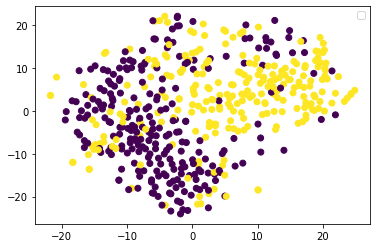

In [12]:
valX = np.load('valX.npy')
valY = np.load('valY.npy')

model.load_state_dict(torch.load('./checkpoints/last_checkpoint.pth'))
model.eval()
latents = inference(valX, model)
pred_from_latent, emb_from_latent = predict(latents)
acc_latent = cal_acc(valY, pred_from_latent)
print('The clustering accuracy is: ', acc_latent)
print('The clustering result:')
plot_scatter(emb_from_latent, valY, savefig='p1_baseline.png')

## Problem 2
- Plot the original and reconstructed images based on the highest test accuracy of AutoEncoder.
- From trainX, we extract images with the indices 1, 2, 3, 6, 7, 9.

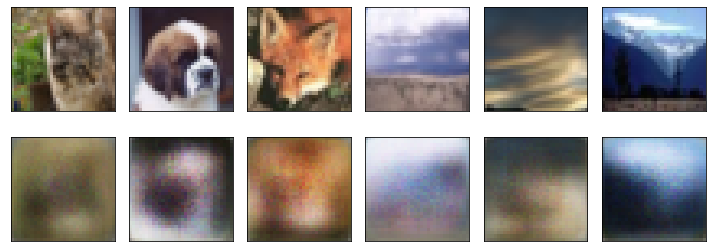

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# draw the oringal image
plt.figure(figsize=(10, 4))
indices = [1, 2, 3, 6, 7, 9]
imgs = trainX[indices, ]
for i, img in enumerate(imgs):
    plt.subplot(2, 6, i + 1, xticks=[], yticks=[])
    plt.imshow(img)

# draw the reconstructed image
inp = torch.Tensor(trainX_preprecessed[indices, ]).cuda()
latents, recs = model(inp)
recs = ((recs + 1) / 2).cpu().detach().numpy()
recs = recs.transpose(0, 2, 3, 1)
for i, img in enumerate(recs):
    plt.subplot(2, 6, 6 + i + 1, xticks=[], yticks=[])
    plt.imshow(img)

plt.tight_layout()

## Problem 3
- Take out 10 checkpoints from the AutoEncoder model training phase to plot the reconstruction error versus validation accuracy.
- Explain what you see from the plot.

In [16]:
import os
import glob

checkpoints_list = sorted(glob.glob('checkpoints/checkpoint_*.pth'), key = lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))

# load the data
dataset = ImgDataset(trainX_preprecessed)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# start prediction
points = []
with torch.no_grad():
    for i, checkpoint in enumerate(checkpoints_list):
        print('[{}/{}] {}'.format(i + 1, len(checkpoints_list), checkpoint))
        model.load_state_dict(torch.load(checkpoint))
        model.eval()
        err = 0
        n = 0
        
        for x in dataloader:
            x = x.cuda()
            _, rec = model(x)
            err += torch.nn.MSELoss(reduction='sum')(x, rec).item()
            n += x.flatten().size(0) # 64*32*32*3?
        print('Reconstruction error (MSE): ', err/n)
        latents = inference(X=valX, model=model) # get the latent code from autoencoder with the model checkpoint
        pred, X_embedded = predict(latents)
        acc = cal_acc(valY, pred)
        print('Accuracy: ', acc)
        points.append((err/n, acc))
        print()

[1/10] checkpoints/checkpoint_10.pth
Reconstruction error (MSE):  0.09170706113179525
Latent Shape:  (500, 4096)
First Reduction Shape:  (500, 200)
Second Reduction Shape:  (500, 2)
Accuracy:  0.514

[2/10] checkpoints/checkpoint_20.pth
Reconstruction error (MSE):  0.0763516991185207
Latent Shape:  (500, 4096)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


First Reduction Shape:  (500, 200)
Second Reduction Shape:  (500, 2)
Accuracy:  0.686

[3/10] checkpoints/checkpoint_30.pth
Reconstruction error (MSE):  0.0685219929265041
Latent Shape:  (500, 4096)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


First Reduction Shape:  (500, 200)
Second Reduction Shape:  (500, 2)
Accuracy:  0.752

[4/10] checkpoints/checkpoint_40.pth
Reconstruction error (MSE):  0.0625512975804946
Latent Shape:  (500, 4096)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


First Reduction Shape:  (500, 200)
Second Reduction Shape:  (500, 2)
Accuracy:  0.506

[5/10] checkpoints/checkpoint_50.pth
Reconstruction error (MSE):  0.058623241985545436
Latent Shape:  (500, 4096)
First Reduction Shape:  (500, 200)
Second Reduction Shape:  (500, 2)
Accuracy:  0.716

[6/10] checkpoints/checkpoint_60.pth
Reconstruction error (MSE):  0.055566501692229625
Latent Shape:  (500, 4096)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


First Reduction Shape:  (500, 200)
Second Reduction Shape:  (500, 2)
Accuracy:  0.698

[7/10] checkpoints/checkpoint_70.pth
Reconstruction error (MSE):  0.05300376256306966
Latent Shape:  (500, 4096)
First Reduction Shape:  (500, 200)
Second Reduction Shape:  (500, 2)
Accuracy:  0.678

[8/10] checkpoints/checkpoint_80.pth
Reconstruction error (MSE):  0.05087475208207673
Latent Shape:  (500, 4096)
First Reduction Shape:  (500, 200)
Second Reduction Shape:  (500, 2)
Accuracy:  0.744

[9/10] checkpoints/checkpoint_90.pth
Reconstruction error (MSE):  0.0490860133264579
Latent Shape:  (500, 4096)
First Reduction Shape:  (500, 200)
Second Reduction Shape:  (500, 2)
Accuracy:  0.658

[10/10] checkpoints/checkpoint_100.pth
Reconstruction error (MSE):  0.047653151886135926
Latent Shape:  (500, 4096)
First Reduction Shape:  (500, 200)
Second Reduction Shape:  (500, 2)
Accuracy:  0.678



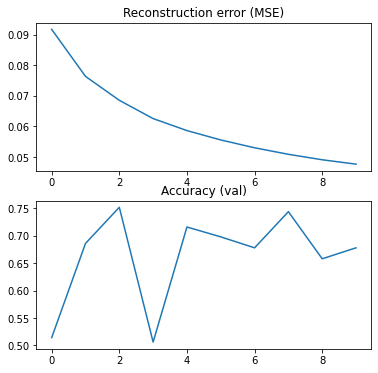

In [17]:
ps = list(zip(*points))
plt.figure(figsize=(6, 6))
plt.subplot(211, title='Reconstruction error (MSE)').plot(ps[0])
plt.subplot(212, title='Accuracy (val)').plot(ps[1])
plt.show()